### Tensorflow를 이용하여 Faster R-CNN기반 Object Detection 구현

In [2]:
# Tensorflow 1.15 설치
!pip uninstall tensorflow
!pip install tensorflow==1.15

Uninstalling tensorflow-2.4.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y


y
y
  Successfully uninstalled tensorflow-2.4.0

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 3.8MB 51.5MB/s 
     |████████████████████████████████| 512kB 53.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=28c560ada2bc077fde7089c9b7f0a283d26a132d67e5c81ec3a765411d0bf619
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
S

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 단일 이미지 Object Detection

(633, 806, 3)


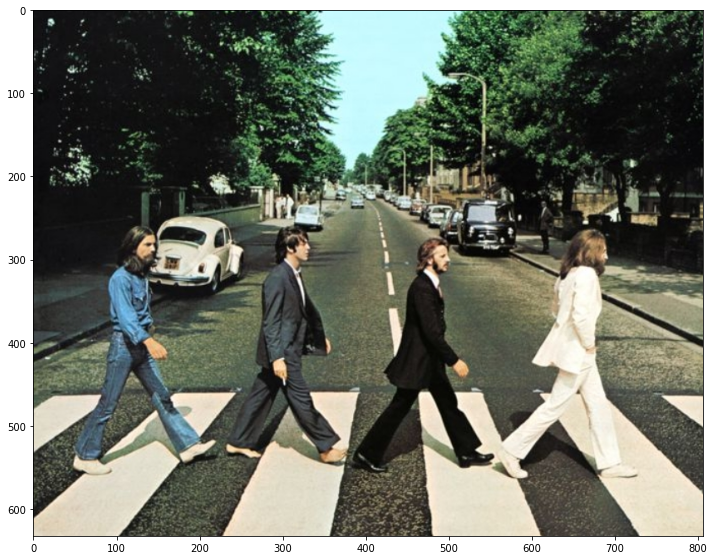

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

!cp /content/drive/MyDrive/detection_lab/beatles01.jpg .
img = cv2.imread('beatles01.jpg')
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
plt.show()

In [6]:
# Tensorflow용 클래스의 ID 정의 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [7]:
# Faster-RCNN pretrained model download 후 압축해제
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt 
!tar zxvf faster_rcnn_resnet50_coco_2018_01_28.tar.gz

# 환경설정 파일 이름 변경하여 이동
!mv faster_rcnn_resnet50_coco_2018_01_28.pbtxt faster_rcnn_resnet50_coco_2018_01_28/config.pbtxt

--2020-12-19 03:01:52--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.240, 2607:f8b0:4004:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

faster_rcnn_resnet5 100%[===================>] 363.69M   345MB/s    in 1.1s    

2020-12-19 03:01:53 (345 MB/s) - ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2020-12-19 03:01:53--  https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Savin

In [9]:
! ls faster_rcnn_resnet50_coco_2018_01_28/

checkpoint    frozen_inference_graph.pb       model.ckpt.index	pipeline.config
config.pbtxt  model.ckpt.data-00000-of-00001  model.ckpt.meta	saved_model


In [28]:
# # Colab에서 입력이 없거나 실행 상태가 아닐때 연결 해제 방지를 위한 코드
# import time

# while True:
#   time.sleep(2)

type of out: <class 'list'> length of out: 4
num_detections: 19
person: 0.9997
person: 0.9993
person: 0.9980
person: 0.9971
car: 0.9222
person: 0.8516
car: 0.8055
car: 0.7322
car: 0.7169
truck: 0.6350
person: 0.6058
car: 0.5482
car: 0.5125
Detection 수행시간: 5.37 초


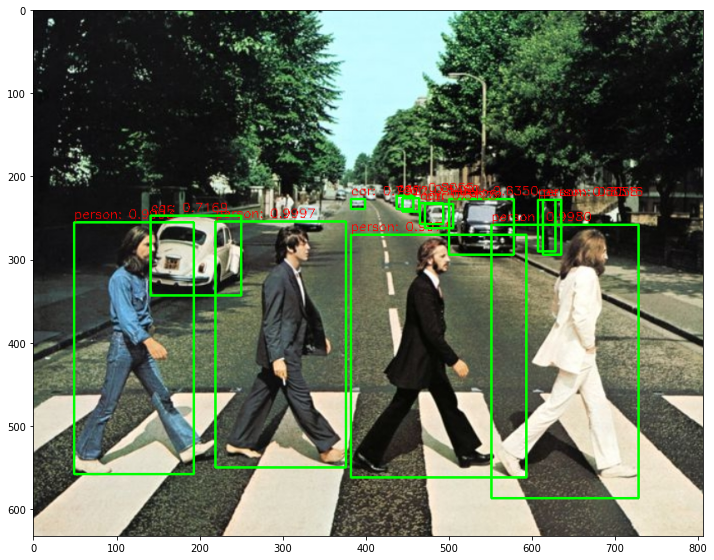

In [25]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline


# Read the graph : 미리 학습된 모델 읽어오기
with tf.gfile.FastGFile('./faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:  # Session객체는 tf 2.0 에서 없어짐
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')  # 예측모델 로딩

    # Read and preprocess an image.
    img = cv2.imread('beatles01.jpg')
    draw_img = img.copy()
    rows = img.shape[0]
    cols = img.shape[1]
    inp = img[:, :, [2, 1, 0]]  # BGR2RGB

    start = time.time()

    # Run the model , Object Detecion 예측 수행
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    print('type of out:',type(out),'length of out:',len(out))  # list, 4
    # print(out)

    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected bounding boxes 시각화
    num_detections = int(out[0][0])
    print('num_detections:', num_detections)

    for i in range(num_detections):
        class_id = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.5:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color , thickness=2)

            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
            print(caption)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
    
    print('Detection 수행시간:',round(time.time() - start, 2),"초")

img_rgb = cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection을 함수로 생성

In [24]:
def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img_array = img_array.copy()
    else:
        draw_img_array = img_array
    
    inp = img_array[:, :, [2, 1, 0]]  # BGR2RGB

    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                    feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # Bounding Box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.5:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv2.rectangle(draw_img_array, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img_array, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
            #print(caption)
    print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img_array

Detection 수행시간: 5.88 초


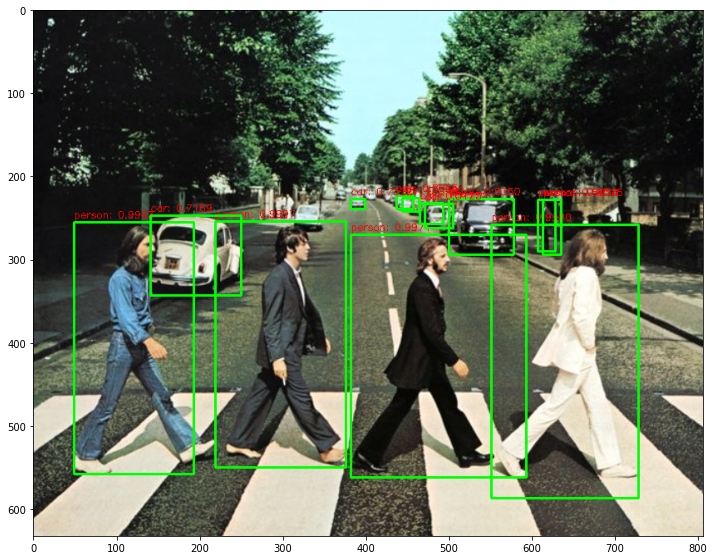

In [26]:
# Read the graph : 미리 학습된 모델 읽어오기
with tf.gfile.FastGFile('./faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:  
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')  # 예측모델 로딩

    # 입력 image 읽어오기
    img = cv2.imread('beatles01.jpg')
    draw_img = get_tensor_detected_image(sess,img,True)

img_rgb = cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)    

#### tensorflow로 Video Object Detection 수행

In [29]:
!cp /content/drive/MyDrive/detection_lab/John_Wick_small.mp4 .
video_input_path = 'John_Wick_small.mp4'

video_output_path = 'John_Wick_small_01_out.avi'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) 
vid_fps = cap.get(cv2.CAP_PROP_FPS )
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, '  FPS:', round(vid_fps), '  Frame 크기:', vid_size)

총 Frame 갯수: 58   FPS: 30   Frame 크기: (1072, 460)


In [30]:
# Read the graph : 미리 학습된 모델 읽어오기
with tf.gfile.FastGFile('./faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:  
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')  # 예측모델 로딩

    while True:
      hasFrame, img_frame = cap.read()
      if not hasFrame:
          print('더 이상 처리할 frame이 없습니다.')
          break
      draw_img_frame =  get_tensor_detected_image(sess, img_frame, False)

      vid_writer.write(draw_img_frame)

vid_writer.release() 
cap.release()

Detection 수행시간: 6.92 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.12 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.1 초
Detection 수행시간: 0.11 초
Detection 수행시간: 0.11 초
Detect

In [31]:
!cp John_Wick_small_01_out.avi /content/drive/MyDrive/detection_lab/